In [1]:
import os
os.chdir(r'/home/fruitspec-lab/FruitSpec/Code/roi/fsCounter')
from MHS.F_model_training import *
from math import radians, cos, sin, asin, sqrt
from vision.misc.help_func import go_up_n_levels

os.chdir(r'/home/fruitspec-lab/FruitSpec/Code/roi/fsCounter/MHS')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/home/fruitspec-lab/anaconda3/envs/FsCounterGPUtest/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
def distance(lat1, lat2, lon1, lon2):
    # convert from degrees to radians
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2

    c = 2 * asin(sqrt(a))

    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371

    # calculate the result
    return (c * r) * 1000  # results in M

def get_row_length(df_jz):
    try:
        if isinstance(df_jz, str):
            df_jz = pd.read_csv(df_jz)
        df_merged = df_jz
        df_merged = df_merged.fillna(method='bfill')

        if df_merged is None: # None where is no overlap between GPS and JZ
            return 0
        first_index = min(df_merged.index)+1
        last_index = max(df_merged.index)
        lat1 = float(df_merged.latitude[first_index])
        lat2 = float(df_merged.latitude[last_index])
        lon1 = float(df_merged.longitude[first_index])
        lon2 = float(df_merged.longitude[last_index])
        
        return distance(lat1, lat2, lon1, lon2), pd.to_datetime(df_merged["JAI_timestamp"]).iloc[0].hour
    except:
        return 0, pd.to_datetime(df_merged["JAI_timestamp"]).iloc[0].hour


def get_valid_row_paths(master_folder):
    paths_list = []
    for root, dirs, files in os.walk(master_folder):
        if np.all([file in files for file in ["jaized_timestamps.csv"]]):
            row_scan_path = os.path.abspath(root)
            paths_list.append(os.path.join(row_scan_path, "jaized_timestamps.csv"))
    return paths_list

def get_full_name_from_path(path_to_row_jz):
    customer_name = os.path.basename(go_up_n_levels(path_to_row_jz,5))
    block_name = os.path.basename(go_up_n_levels(path_to_row_jz,4))
    row_name = "R" + os.path.basename(go_up_n_levels(path_to_row_jz,2)).split("_")[-1]
    scan_name = "S" + os.path.basename(go_up_n_levels(path_to_row_jz,1)).split("_")[-1]
    full_name = f"{customer_name}_{block_name}_{row_name}_{scan_name}"
    return full_name

def run_on_folder(master_folder, njobs=1):
    paths_list = get_valid_row_paths(master_folder)
    n = len(paths_list)
    if njobs > 1:
        with ProcessPoolExecutor(max_workers=njobs) as executor:
            res = list(executor.map(get_row_length, paths_list))
    else:
        res = list(map(get_row_length, paths_list))
    res_names = list(map(get_full_name_from_path, paths_list))
    return dict(zip(res_names, res))

        
master_folder = "/media/fruitspec-lab/cam175/MEHADRINEXP"
row_lengths = run_on_folder(master_folder)


row_lengths

{'MEHADRINEXP_BEERAMU0_R101_S1': (74.41816726121135, 10),
 'MEHADRINEXP_BEERAMU0_R102_S1': (71.8968133954595, 10),
 'MEHADRINEXP_BEERAMU0_R105_S1': (70.44076024862697, 13),
 'MEHADRINEXP_BEERAMU0_R106_S1': (70.10898433432772, 13),
 'MEHADRINEXP_BEERAMU0_R107_S1': (70.65422776056182, 13),
 'MEHADRINEXP_BEERAMU0_R108_S1': (77.59997937232808, 13),
 'MEHADRINEXP_BEERAMU0_R18_S1': (74.14636918394972, 16),
 'MEHADRINEXP_BEERAMU0_R19_S1': (69.181578595321, 16),
 'MEHADRINEXP_BEERAMU0_R20_S1': (72.47014124681026, 16),
 'MEHADRINEXP_BEERAMU0_R21_S1': (71.04436410659146, 16),
 'MEHADRINEXP_BEERAMU0_R23_S1': (70.5011800399214, 16),
 'MEHADRINEXP_BEERAMU0_R24_S1': (71.19340778185054, 16),
 'MEHADRINEXP_BEERAMU0_R2_S1': (73.4919346211541, 9),
 'MEHADRINEXP_BEERAMU0_R3_S1': (69.43683695363933, 9),
 'MEHADRINEXP_BEERAMU0_R4_S1': (69.71435579789183, 10),
 'MEHADRINEXP_BEERAMU0_R5_S1': (69.11171721359425, 10),
 'MEHADRINEXP_BEERAMU0_R6_S1': (70.81104949240994, 10),
 'MEHADRINEXP_BEERAMU0_R7_S1': (76.88

In [3]:
def get_valid_row_paths_n_tracks(master_folder):
    paths_list = []
    for root, dirs, files in os.walk(master_folder):
        if np.all([file in files for file in ["tracks.csv"]]):
            row_scan_path = os.path.abspath(root)
            paths_list.append(os.path.join(row_scan_path, "tracks.csv"))
    return paths_list

def get_n_tracks(tracks_path):
    df_tracks = pd.read_csv(tracks_path)
    uniq, counts = np.unique(df_tracks["track_id"], return_counts=True)
    df_alignment = pd.read_csv(tracks_path.replace("tracks", "alignment"))
    n_dropped = df_alignment["frame"].max()+1 - len(df_alignment["frame"].unique())
    n_dets = len(df_tracks["track_id"])
#     track_id_depth = df_tracks.groupby("track_id")["depth"].median()
#     depth_1 = track_id_depth[np.isin(track_id_depth.index, uniq)].median()
#     depth_2 = track_id_depth[np.isin(track_id_depth.index, uniq[counts>1])].median()
#     depth_3 = track_id_depth[np.isin(track_id_depth.index, uniq[counts>2])].median()
#, depth_1, depth_2, depth_3
    return len(uniq), len(uniq[counts>1]), len(uniq[counts>2]), n_dets, n_dropped 

def run_on_folder_tracks(master_folder, njobs=1):
    paths_list = get_valid_row_paths_n_tracks(master_folder)
    n = len(paths_list)
    if njobs > 1:
        with ProcessPoolExecutor(max_workers=njobs) as executor:
            res = list(executor.map(get_n_tracks, paths_list))
    else:
        res = list(map(get_n_tracks, paths_list))
    res_names = list(map(get_full_name_from_path, paths_list))
    return dict(zip(res_names, res))

        
n_tracks = run_on_folder_tracks(master_folder)


n_tracks

{'MEHADRINEXP_BEERAMU0_R101_S1': (9927, 5622, 3876, 28605, 0.0),
 'MEHADRINEXP_BEERAMU0_R102_S1': (7500, 3800, 2186, 17702, 0.0),
 'MEHADRINEXP_BEERAMU0_R105_S1': (9649, 5479, 3841, 30598, 0.0),
 'MEHADRINEXP_BEERAMU0_R106_S1': (12653, 6892, 4826, 41056, 0.0),
 'MEHADRINEXP_BEERAMU0_R107_S1': (11856, 6629, 4756, 39595, 0.0),
 'MEHADRINEXP_BEERAMU0_R108_S1': (9836, 5336, 3741, 30171, 0.0),
 'MEHADRINEXP_BEERAMU0_R18_S1': (7885, 3949, 2456, 19110, 4.0),
 'MEHADRINEXP_BEERAMU0_R19_S1': (11273, 5897, 3757, 28371, 0.0),
 'MEHADRINEXP_BEERAMU0_R20_S1': (8742, 4490, 2901, 23106, 12.0),
 'MEHADRINEXP_BEERAMU0_R21_S1': (11852, 6230, 4003, 30641, 0.0),
 'MEHADRINEXP_BEERAMU0_R23_S1': (8974, 4690, 3152, 25190, 0.0),
 'MEHADRINEXP_BEERAMU0_R24_S1': (11503, 6009, 3918, 29462, 16.0),
 'MEHADRINEXP_BEERAMU0_R2_S1': (10631, 5691, 3575, 27029, 0.0),
 'MEHADRINEXP_BEERAMU0_R3_S1': (10414, 4964, 2997, 24138, 0.0),
 'MEHADRINEXP_BEERAMU0_R4_S1': (13045, 6852, 4512, 38285, 0.0),
 'MEHADRINEXP_BEERAMU0_R5_S

In [5]:
df_out = pd.DataFrame(n_tracks).T
df_out.columns = ["cv1", "cv2", "cv3", "n_dets", "ndropped"] #"depth_1", "depth_2", "depth_3"]
df_out.reset_index(names = "block", inplace = True)
row_len_df = pd.DataFrame(row_lengths).T
row_len_df.columns = ["row_len" , "time"]
df_out = df_out.merge(row_len_df.rename_axis('block'), on = "block")
for i in range(1,4):
    df_out[f"cv{i}_per_meter"] = df_out[f"cv{i}"]/df_out["row_len"]
df_out[f"dets_per_meter"] = df_out["n_dets"]/df_out["row_len"]
df_out = df_out[df_out["row_len"] > 60].reset_index(drop = True)
# df_out["time"] = df_out["time"].map({9: 'morning',
#                                      10: 'morning',
#            12: 'noon',
#            13: 'noon',
#            15: "sundown",
#            16: "sundown"})
# df_out.sort_values("block")

In [6]:
df_out["counter_row"] = df_out["block"].apply(lambda x: x.split("_")[2][1:]).apply(int)
df_out["block_name"] = df_out["block"].apply(lambda x: x.split("_")[1])

In [7]:
real_row_path = "/media/fruitspec-lab/cam175/F_dfs/MEHADRINEXP_row_tags.csv"
df_real_row = pd.read_csv(real_row_path, encoding='ISO-8859-1')

In [8]:
df_out["row"] = df_out["block_name"] + "_R" + df_out["counter_row"].apply(str)

In [9]:
df_real_row["row"] = df_real_row["Block_name_row_tags"] +  "_R" + df_real_row["counter_row"].apply(str)

In [10]:
df_out = df_out.merge(df_real_row.set_index("row").drop("counter_row", axis = 1), on = "row")

In [11]:
df_out["sunside"] = df_out["sunside"].apply(lambda x: x.replace("back", "rear") if isinstance(x,str) else x)

In [12]:
# OR2009
# B sundown = towards sun
# B morning = sun is behind
# A morning = towards sun
# A sundown = sun is behind
grp_res = df_out.groupby(["real_row", "sunside", "block_name"]).median().drop(
    ["counter_row", "row_len", "ndropped"],axis = 1).reset_index()
grp_res["cv2/cv1"] = grp_res["cv2"]/grp_res["cv1"]
grp_res["cv3/cv1"] = grp_res["cv3"]/grp_res["cv1"]
grp_res

,real_row,sunside,block_name,cv1,cv2,cv3,n_dets,time,cv1_per_meter,cv2_per_meter,cv3_per_meter,dets_per_meter,cv2/cv1,cv3/cv1
0,1,front,OR2009,26700.0,13310.0,7783.0,63901.0,15.0,172.922665,86.202272,49.105050,402.985649,0.498502,0.291498
1,1,noon,OR2009,18579.5,11930.0,9291.5,76303.0,12.0,127.247322,81.164533,61.784111,493.452138,0.642106,0.500094
2,1,rear,OR2009,15884.0,9970.0,7601.5,64815.0,12.0,100.483881,62.042929,47.809809,407.749259,0.627676,0.478563
3,2,front,OR2009,23733.5,13236.5,8378.5,66694.0,12.0,148.968506,82.868159,51.985457,419.645356,0.557714,0.353024
4,2,noon,OR2009,14696.5,9101.5,7005.5,57324.5,13.0,93.736315,57.771304,44.109630,385.966163,0.619297,0.476678
5,2,rear,OR2009,11549.5,7070.0,5357.0,41763.0,12.0,72.578955,44.097582,33.409057,260.816852,0.612148,0.463830
6,3,noon_side_front,ORSCHIST,8866.0,4678.0,3383.0,29208.0,12.0,94.962860,50.105601,36.234983,312.844035,0.527634,0.381570
7,3,noon_side_rear,ORSCHIST,8464.0,4527.0,3228.0,27450.0,12.0,86.947578,47.161129,34.956630,289.312678,0.534853,0.381380
8,3,side_front,ORSCHIST,9515.0,5039.0,3676.0,32367.0,12.5,97.348414,51.363269,37.840746,334.102412,0.529585,0.386337
9,3,side_rear,ORSCHIST,9768.5,5126.5,3775.0,35858.5,12.5,94.881062,50.755790,37.737646,354.924665,0.524799,0.386446


In [13]:
grp_res["block_row"] = grp_res["block_name"] + "_R" + grp_res["real_row"].apply(str)

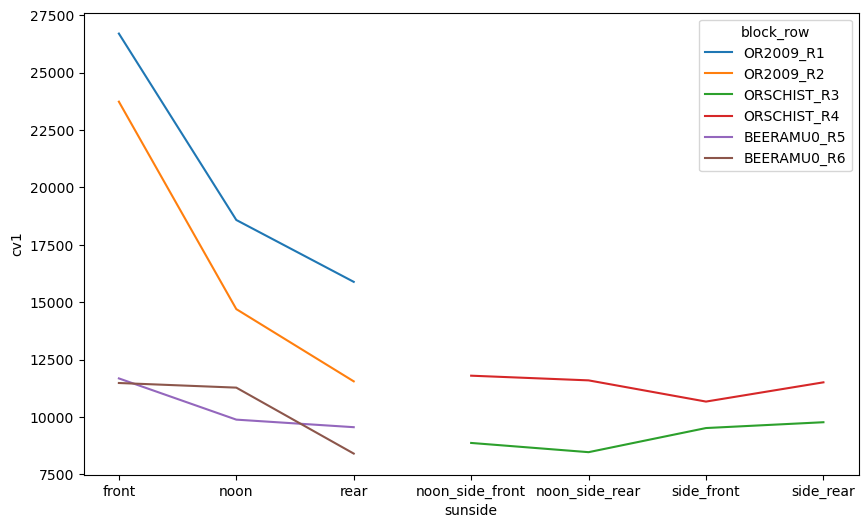

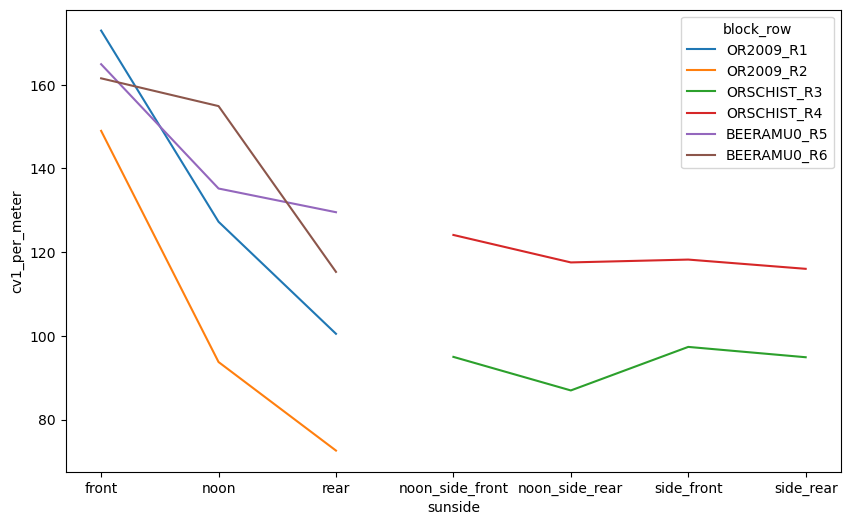

In [14]:
plt.figure(figsize = (10,6))
sns.lineplot(data = grp_res, x = "sunside", y= "cv1", hue = "block_row")
plt.show()
plt.figure(figsize = (10,6))
sns.lineplot(data = grp_res, x = "sunside", y= "cv1_per_meter", hue = "block_row")
plt.show()

# CV sunside analysis after slicing

In [15]:
or2009_cv_features = "/media/fruitspec-lab/cam175/customers_new/MOTCHA/OR2009/cv_features.csv"
BEERAMU0_cv_features = "/media/fruitspec-lab/cam175/customers_new/MOTCHA/BEERAMU0/cv_features.csv"
ORSHICHT_cv_features = "/media/fruitspec-lab/cam175/customers_new/MOTCHA/ORSCHIST/cv_features.csv"
cv_features_paths = [or2009_cv_features, BEERAMU0_cv_features, ORSHICHT_cv_features]
cv_df = pd.concat([pd.read_csv(p) for p in cv_features_paths])

In [16]:
cv_df["row"] = cv_df["block_name"] + "_" + cv_df["name"].apply(lambda x: x.split("_")[0])
value_counts = cv_df['row'].value_counts()
valid_row = list(value_counts[value_counts==1].index)
valid_trees = (cv_df["name"][cv_df["name"].str.contains("T11")]).values
cv_df_valid = cv_df[np.isin(cv_df["row"], valid_row) | np.isin(cv_df["name"], valid_trees)]

In [17]:
cv_df_valid = cv_df_valid.merge(df_real_row.set_index("row").drop("counter_row", axis = 1), on = "row")
cv_df_valid["sunside"] = cv_df_valid["sunside"].apply(lambda x: x.replace("back", "rear"))


In [18]:
cv_df_valid["block_real_row"] = cv_df_valid["block_name"] + "_R" + cv_df_valid["real_row"].apply(str)

In [19]:
cv_df_valid[["cv1", "real_row", "sunside", "block_name", "row"]].sort_values(["real_row", "sunside"])

,cv1,real_row,sunside,block_name,row
8,5277,1,front,OR2009,OR2009_R54
10,4138,1,front,OR2009,OR2009_R7
1,3179,1,noon,OR2009,OR2009_R29
2,3806,1,noon,OR2009,OR2009_R32
7,2586,1,rear,OR2009,OR2009_R53
9,3515,1,rear,OR2009,OR2009_R6
6,4667,2,front,OR2009,OR2009_R47
11,4485,2,front,OR2009,OR2009_R9
3,3145,2,noon,OR2009,OR2009_R33
4,3159,2,noon,OR2009,OR2009_R34


In [20]:
grp_res_cv = cv_df_valid.groupby(["real_row", "sunside", "block_name"]).median().reset_index()
grp_res_cv["block_real_row"] = grp_res_cv["block_name"] + "_R" + grp_res_cv["real_row"].apply(str)
grp_res_cv = grp_res_cv.sort_values(["block_name","sunside"])

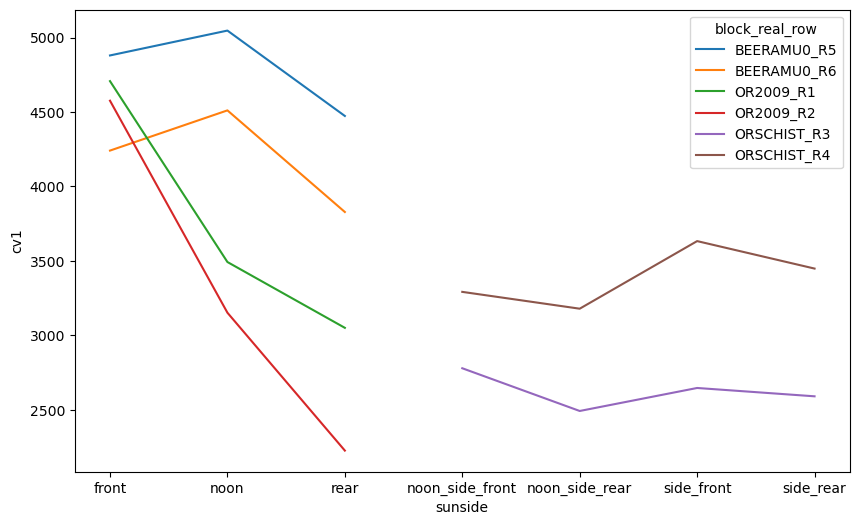

In [21]:
plt.figure(figsize = (10,6))
sns.lineplot(data = grp_res_cv, x = "sunside", y= "cv1", hue = "block_real_row")
plt.show()

In [22]:
dfs_list = []
for real_row in grp_res_cv["real_row"].unique():
    real_row_subdf = grp_res_cv[grp_res_cv["real_row"] == real_row]
    if not "side" in real_row_subdf["sunside"].iloc[0]:
        real_row_subdf = grp_res_cv[grp_res_cv["real_row"] == real_row]
        front_cv = real_row_subdf[real_row_subdf["sunside"] == "front"].reset_index(drop=True)[[f"cv{i}" for i in range(1,6)]]                                                                            
        noon_cv = real_row_subdf[real_row_subdf["sunside"] == "noon"].reset_index(drop=True)[[f"cv{i}" for i in range(1,6)]]
        rear_cv = real_row_subdf[real_row_subdf["sunside"] == "rear"].reset_index(drop=True)[[f"cv{i}" for i in range(1,6)]]
        ratios_df = pd.concat([front_cv/noon_cv, rear_cv/noon_cv])
        ratios_df["real_row"] = real_row
        ratios_df["sunside"] = ["front", "rear"]
        dfs_list.append(ratios_df)
factor_ratios = pd.concat(dfs_list)


In [23]:
factor_ratios

,cv1,cv2,cv3,cv4,cv5,real_row,sunside
0,0.966911,0.917331,0.800793,0.698978,0.589194,5,front
0,0.886368,0.787750,0.719029,0.676228,0.638937,5,rear
0,0.940146,0.877965,0.816852,0.743429,0.668014,6,front
0,0.848703,0.759376,0.722937,0.701844,0.692269,6,rear
0,1.347888,1.053584,0.793343,0.590650,0.454965,1,front
0,0.873443,0.893978,0.903177,0.884835,0.874827,1,rear
0,1.451777,1.313620,1.109207,0.950993,0.799686,2,front
0,0.706218,0.708653,0.712366,0.701732,0.691423,2,rear


In [24]:
factor_ratios.groupby("sunside").median()

,cv1,cv2,cv3,cv4,cv5,real_row
sunside,,,,,,
front,1.157400,0.985457,0.808822,0.721203,0.628604,3.5
rear,0.861073,0.773563,0.720983,0.701788,0.691846,3.5


# F_modeling

### Load data

In [25]:
features_df = cv_df.copy()
f_df = pd.read_csv("/media/fruitspec-lab/cam175/F_dfs/MEHADRINEXP_F.csv")


In [26]:
features_df["full_name"] = features_df["block_name"] + "_" + features_df["name"]
f_df["full_name"] = f_df["block_name"] + "_" + f_df["new_tree_name"]

In [27]:
features_df["real_row"] = features_df["row"].map(dict(zip(df_real_row["row"],
                                                              df_real_row["Block_name_row_tags"] +
                                                          "_R" + df_real_row["real_row"].apply(str))))
features_df["sunside"] = features_df["row"].map(dict(zip(df_real_row["row"], df_real_row["sunside"])))
features_df["side"] = features_df["row"].map(dict(zip(df_real_row["row"], df_real_row["side"])))

In [28]:
# merge F on name
df_f_org = features_df
df_f_org["F"] = features_df["full_name"].map(dict(zip(f_df["full_name"], f_df["F"])))

In [29]:
df_f_org = df_f_org[~df_f_org["F"].isna()].reset_index(drop = True)

In [30]:
df_f_org[[f"cv{i}" for i in range(1,6)] + 
         ["F", "name", "block_name"]].to_csv("/media/fruitspec-lab/cam175/MEHADRINEXP/MEHADRINEXP_cv_and_F.csv")


In [31]:
cv_cols = [f"cv{i}" for i in range(1,6)]
cv_F_cols = [f"{col}/F" for col in cv_cols]
for cv_col, cv_F_col in zip(cv_cols, cv_F_cols):
    df_f_org[cv_F_col] = df_f_org[cv_col]/df_f_org["F"]

In [32]:
# df_f_org.to_csv(f"{df_f_path.split('.')[0]}_cvf.csv")

### Short EDA

In [33]:
df_f_org[df_f_org["side"] == "B"][cv_F_cols].mean().round(2)

cv1/F    0.56
cv2/F    0.32
cv3/F    0.23
cv4/F    0.18
cv5/F    0.15
dtype: float64

In [34]:
df_f_org.groupby(["block_name"])[cv_F_cols].mean().round(2)

,cv1/F,cv2/F,cv3/F,cv4/F,cv5/F
block_name,,,,,
BEERAMU0,0.69,0.37,0.26,0.19,0.15
OR2009,0.40,0.25,0.19,0.15,0.12
ORSCHIST,0.57,0.31,0.23,0.18,0.15


In [35]:
df_f = df_f_org.copy()

### CV-F graphs

In [36]:
def plot_F_cv(df,min_samp = "", hue = None, title= "", col = ""):
    if col == "":
        col = f"cv{min_samp}"
    max_val = np.min(np.max(df[[col, "F"]].values, axis = 0))
    ax = sns.lmplot(data = df, x = col, y="F", hue = hue)
    sns.regplot(data = df, x = col, y="F", scatter_kws={'s':2}, order = 1,ci=0, ax=ax.axes[0,0],
               x_ci = 0, color = "black", line_kws={"ls":"--"},scatter=False)
    plt.plot([0, max_val], [0, max_val], color='grey')
    plt.ylim(0, np.max(df["F"]*1.1))
    plt.title(title)
    plt.show()

<Figure size 1000x600 with 0 Axes>

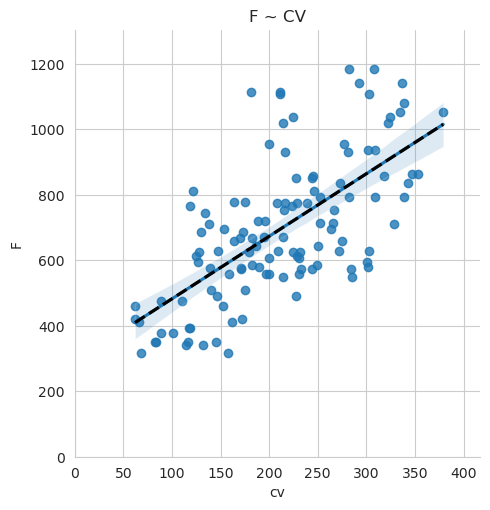

In [37]:

df = df_f_org.copy()
col = 'cv2'
max_val = np.min(np.max(df[[col, "F"]].values, axis=0))

plt.figure(figsize=(10, 6))  # Adjust figure size

# Enable grid lines
sns.set_style("whitegrid")

ax = sns.lmplot(data=df, x=col, y="F", palette="Blues")  # Customize color palette
sns.regplot(data=df, x=col, y="F", scatter_kws={'s': 5}, order=1, ci=0, ax=ax.axes[0, 0],
            x_ci=0, color="black", line_kws={"ls": "--"},scatter=False)  # Adjust scatter marker size and line style

plt.xlim(0, np.max(df[col] * 1.1))  # Adjust x-axis limits
plt.ylim(0, np.max(df["F"] * 1.1))  # Adjust y-axis limits

plt.xlabel("cv")  # Set x-axis label
plt.ylabel("F")  # Set y-axis label
plt.title("F ~ CV")  # Set plot title

plt.show()

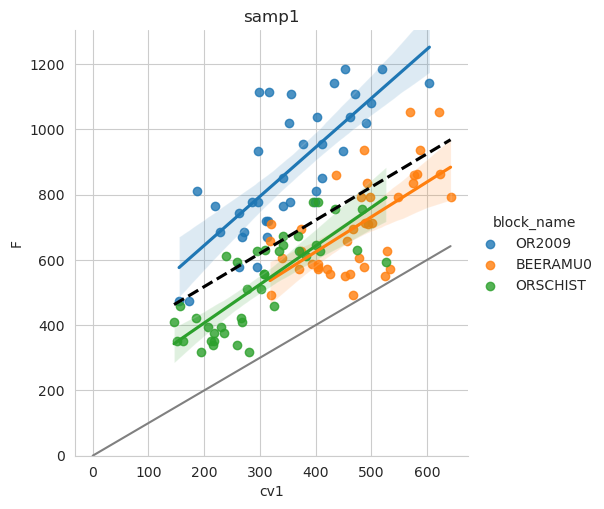

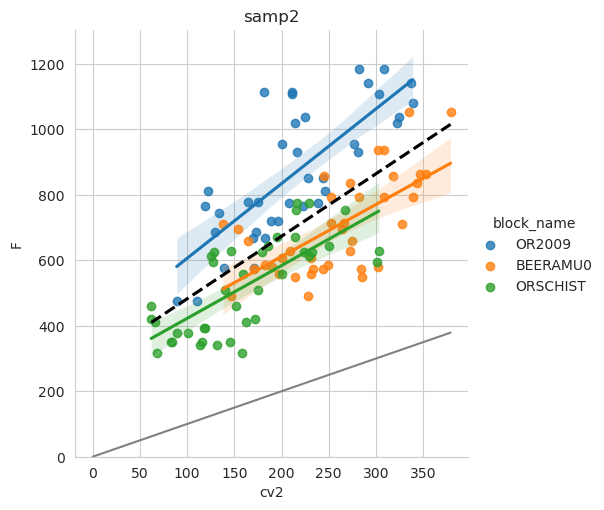

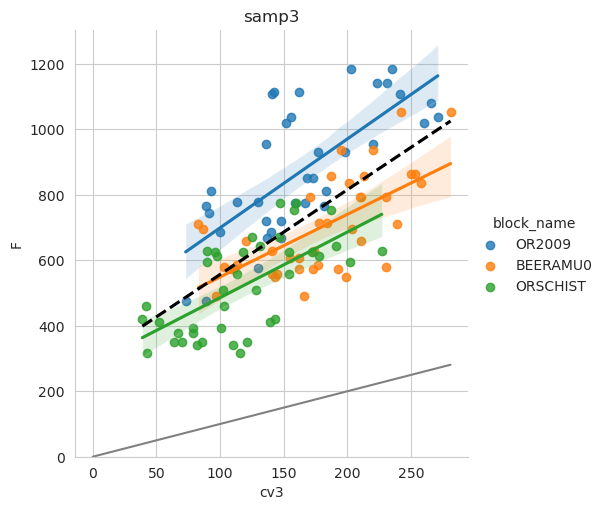

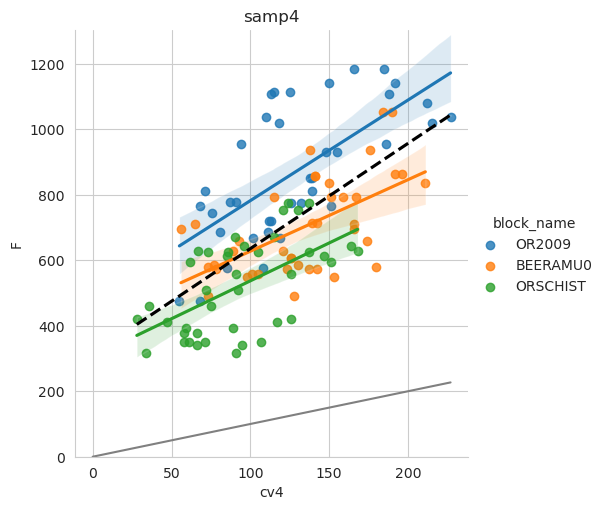

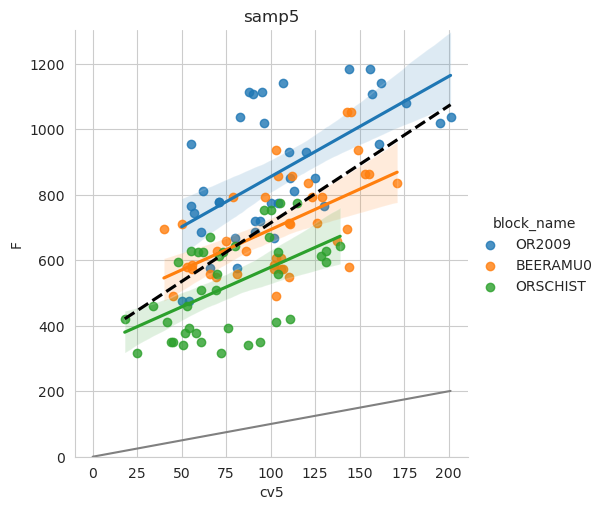

In [38]:
for i in range(1,6):
    plot_F_cv(df_f,i,"block_name", f"samp{i}")

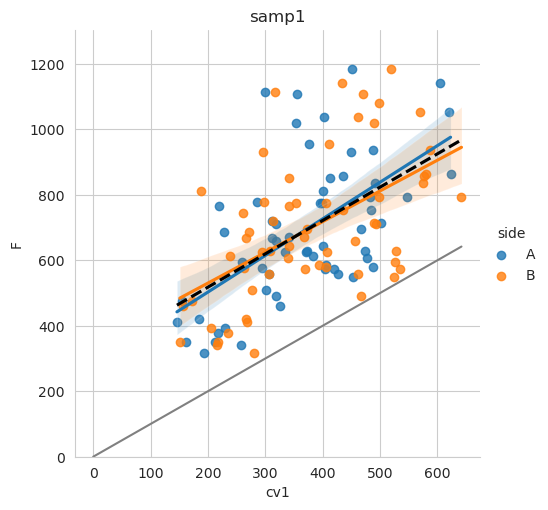

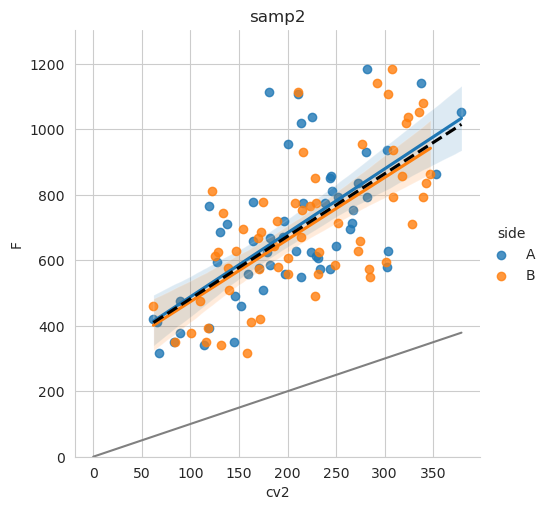

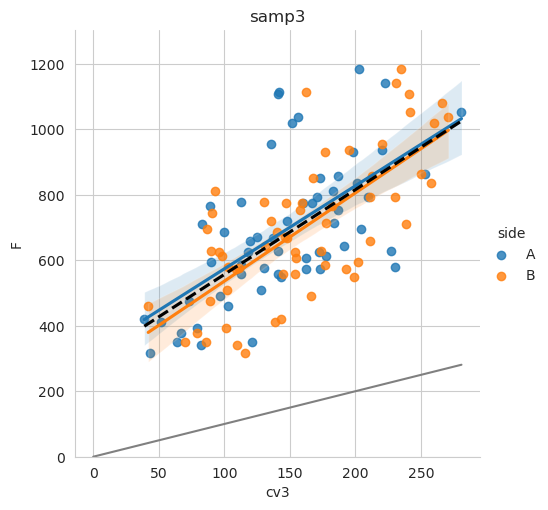

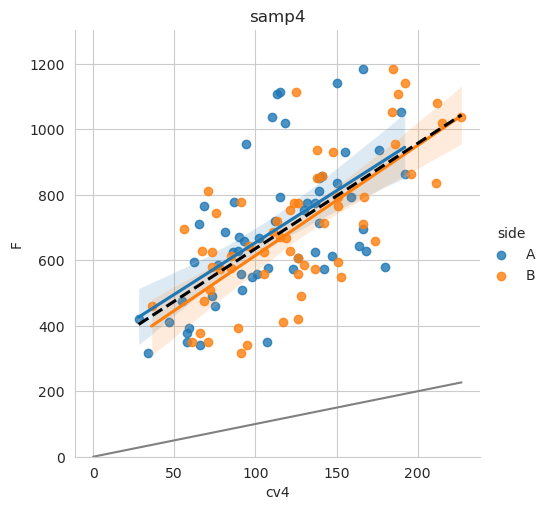

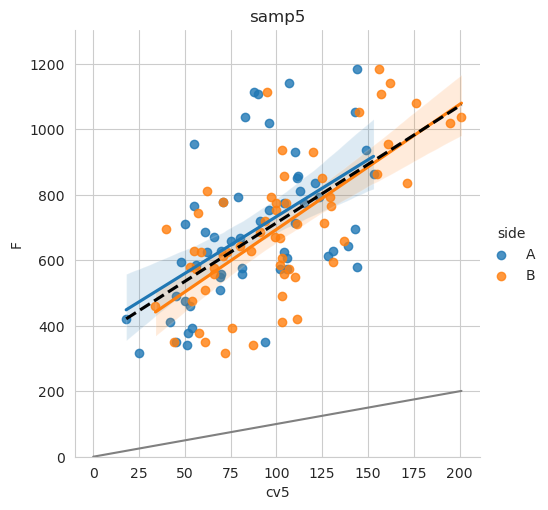

In [39]:
for i in range(1,6):
    plot_F_cv(df_f,i,"side", f"samp{i}")

### Modeling

In [40]:
import sys
sys.path.append(r'/home/fruitspec-lab/FruitSpec/Code/roi/fsCounter')

from MHS.scoring import cross_validate_with_mean
from sklearn.linear_model import LinearRegression, PoissonRegressor

class MaxLinearRegressor(LinearRegression):
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True, n_jobs=None):
        super().__init__(fit_intercept=fit_intercept, normalize=normalize, copy_X=copy_X, n_jobs=n_jobs)
    
    def predict(self, X):
        predicted_values = super().predict(X)
        return np.array([max(p, 0) for p in predicted_values])

In [80]:
df = df_f.reset_index(drop = True).copy()
# df = df_f[df_f["block_name"]!="FREDIANI"].reset_index(drop = True).copy()
df["row"] = df.apply(lambda x: f'{x["block_name"]}: {x["name"].split("_")[0]}', axis = 1)

from sklearn.linear_model import LinearRegression, PoissonRegressor

X = df[["cv5"]]
# X["cv2^2"] = X["cv2"]**2
y = df["F"]
model = LinearRegression(fit_intercept = False)
print(cross_validate_with_mean(model, X, y, groups=df["row"]))
print(cross_validate_with_mean(model, X, y, groups=df["block_name"]))
model.fit(X,y)
print(model.intercept_, model.coef_)

true: 12340.0,    pred: 12295.340354852016. (0.36 %) (ORSCHIST: R4)
true: 8508.0,    pred: 8805.17291769039. (3.49 %) (ORSCHIST: R3)
true: 16858.0,    pred: 12136.342790240895. (28.01 %) (OR2009: R2)
true: 13360.0,    pred: 13057.457324643863. (2.26 %) (BEERAMU0: R6)
true: 14748.0,    pred: 15820.264073017532. (7.27 %) (BEERAMU0: R5)
true: 14334.0,    pred: 12691.831982735088. (11.46 %) (OR2009: R1)
0.26794402876723045 0.03988412247494442
(0.08809124665339176, 0.09313409352894966)
true: 20848.0,    pred: 21402.7403547917. (2.66 %) (ORSCHIST)
true: 28108.0,    pred: 29663.048101877095. (5.53 %) (BEERAMU0)
true: 31192.0,    pred: 23625.649697834084. (24.26 %) (OR2009)
0.27953579594179506 0.021879997899307772
(0.10816875662190469, 0.09575873339988304)
0.0 [6.84904744]


In [84]:
df = df_f.reset_index(drop = True).copy()
# df = df_f[df_f["block_name"]!="FREDIANI"].reset_index(drop = True).copy()
df["row"] = df.apply(lambda x: f'{x["block_name"]}: {x["name"].split("_")[0]}', axis = 1)

from sklearn.linear_model import LinearRegression, PoissonRegressor
for block in df["block_name"].unique():
    logic_vec = df["block_name"] == block
    X = df[logic_vec][["cv5"]].reset_index(drop = True)
    # X["cv2^2"] = X["cv2"]**2
    y = df[logic_vec]["F"].reset_index(drop = True)
    model = LinearRegression(fit_intercept = False)
    print(cross_validate_with_mean(model, X, y, groups=df[logic_vec]["row"].reset_index(drop = True)))
    model.fit(X,y)
    print(model.coef_)

true: 16858.0,    pred: 13139.755692978968. (22.06 %) (OR2009: R2)
true: 14334.0,    pred: 15993.936509474865. (11.58 %) (OR2009: R1)
0.25365119215718146 0.01704594500197945
(0.1681833687268623, 0.05237923104897304)
[7.72338588]
true: 13360.0,    pred: 11856.16413566048. (11.26 %) (BEERAMU0: R6)
true: 14748.0,    pred: 14682.527953160932. (0.44 %) (BEERAMU0: R5)
0.2283919225653482 0.030907395996098458
(0.05850097474154923, 0.05406158995452266)
[6.37905902]
true: 12340.0,    pred: 10628.007014222088. (13.87 %) (ORSCHIST: R4)
true: 8508.0,    pred: 8114.858667761469. (4.62 %) (ORSCHIST: R3)
0.3067354786787839 0.01590383966619871
(0.0924718406073621, 0.04626340945567773)
[6.24498002]


In [43]:
df = df_f.reset_index(drop = True).copy()
# df = df_f[df_f["block_name"]!="FREDIANI"].reset_index(drop = True).copy()
df["row"] = df.apply(lambda x: f'{x["block_name"]}: {x["name"].split("_")[0]}', axis = 1)

from sklearn.linear_model import LinearRegression, PoissonRegressor
for block in df["block_name"].unique():
    logic_vec = df["block_name"] == block
    X = df[logic_vec][["cv1"]].reset_index(drop = True)
    # X["cv2^2"] = X["cv2"]**2
    y = df[logic_vec]["F"].reset_index(drop = True)
    model = LinearRegression(fit_intercept=True)
    print(cross_validate_with_mean(model, X, y, groups=df[logic_vec]["row"].reset_index(drop = True)))
    model.fit(X,y)
    print(model.intercept_, model.coef_)

true: 8429.0,    pred: 8068.289650529408. (4.28 %) (OR2009: R34)
true: 8429.0,    pred: 8058.072134846598. (4.40 %) (OR2009: R33)
true: 8991.0,    pred: 9261.12689664271. (3.00 %) (OR2009: R32)
true: 7167.0,    pred: 7658.60596070596. (6.86 %) (OR2009: R29)
0.1292160642975351 0.037755562757220536
(0.04635931358393032, 0.013953227228123522)
343.31265083744756 [1.50366081]
true: 6680.0,    pred: 6477.827112920446. (3.03 %) (BEERAMU0: R114)
true: 6680.0,    pred: 6804.647232752402. (1.87 %) (BEERAMU0: R113)
true: 7374.0,    pred: 6951.569214927062. (5.73 %) (BEERAMU0: R108)
true: 7374.0,    pred: 7878.240451874875. (6.84 %) (BEERAMU0: R107)
0.13748729507561305 0.025742293624270267
(0.04364813612427422, 0.020007681450230123)
195.61300390648972 [1.07206553]
true: 4254.0,    pred: 4889.897159388134. (14.95 %) (ORSCHIST: R6)
true: 4254.0,    pred: 4738.873144711613. (11.40 %) (ORSCHIST: R5)
true: 6170.0,    pred: 5568.234230542867. (9.75 %) (ORSCHIST: R45)
true: 6170.0,    pred: 5694.46548006

# 2 sided test

In [44]:
# f_df_serinal["base_tree_name"] = base_tree_name
# f_df_serinal["tree_new_name"] = tree_new_name
# features_df[features_df["customer"].isin(["FOWLER", "MOTCHA"])]["full_name"]
# features_df.loc[:, "name"] = features_df["full_name"].map(dict(zip(f_df_serinal["full_name"],
#                                                                    f_df_serinal["tree_new_name"])))
# features_df["side"] = features_df["full_name"].map(dict(zip(f_df_serinal["full_name"],
#                                                                    f_df_serinal["side"])))

In [45]:
features_df["full_name"] = features_df["block_name"] + "_" + features_df["name"]
f_df["full_name"] = f_df["block_name"] + "_" + f_df["new_tree_name"]
f_df_serinal = f_df[~f_df["tree_serial"].isna()]
f_df_serinal["side"].replace({"A":1, "B":2}, inplace=True)

f_df_serinal["real_row"] = f_df_serinal["full_name"].map(dict(zip(features_df["full_name"],
                                      features_df["real_row"])))
f_df_serinal["real_row"].fillna("OR2009_R1", inplace = True)

base_tree_name = f_df_serinal["real_row"] + "_T" + f_df_serinal["tree_serial"].astype(int).astype(str)
tree_new_name = base_tree_name + "_S" + f_df_serinal["side"].replace({"A":1, "B":2}).astype(int).astype(str)
tree_new_name = tree_new_name.apply(lambda x: f'{x.split("_")[1]}_{x.split("_")[3]}_{x.split("_")[2]}')
f_df_serinal["base_tree_name"] = base_tree_name
f_df_serinal["tree_new_name"] = tree_new_name
features_df[features_df["customer"].isin(["FOWLER", "MOTCHA"])]["full_name"]
features_df.loc[:, "name"] = features_df["full_name"].map(dict(zip(f_df_serinal["full_name"],
                                                                   f_df_serinal["tree_new_name"])))
features_df["side"] = features_df["full_name"].map(dict(zip(f_df_serinal["full_name"],
                                                                   f_df_serinal["side"])))

In [46]:
df_f = features_df[~features_df["F"].isna()].copy().reset_index(drop=True)
cv_cols = ["cv1", "cv2", "cv3", "cv4" ,"cv5"]

df_f["base_tree_name"] = df_f["block_name"] + "_"  + df_f["name"].apply(lambda x: x.split("_")[0] + "_" + x.split("_")[-1])
counts = df_f["base_tree_name"].value_counts()>1
df_f = df_f[df_f["base_tree_name"].map(dict(zip(counts.index, counts.values)))]


In [47]:
grouped_trees = df_f.groupby("base_tree_name")[cv_cols + ["F"]].mean()
grouped_trees[cv_cols] = grouped_trees[cv_cols]*2
grouped_trees["base_tree_name"] = list(grouped_trees.index)
grouped_trees["block_name"] = grouped_trees["base_tree_name"].apply(lambda x: x.split("_")[0])

In [48]:
cv_cols = [f"cv{i}" for i in range(1,6)]
cv_F_cols = [f"{col}/F" for col in cv_cols]
for cv_col, cv_F_col in zip(cv_cols, cv_F_cols):
    grouped_trees[cv_F_col] = grouped_trees[cv_col]/grouped_trees["F"]
grouped_trees.groupby("block_name")[cv_F_cols].mean().round(2)

,cv1/F,cv2/F,cv3/F,cv4/F,cv5/F
block_name,,,,,
BEERAMU0,1.37,0.74,0.52,0.39,0.30
OR2009,0.81,0.49,0.37,0.29,0.24
ORSCHIST,1.15,0.62,0.45,0.36,0.30


In [49]:
def get_model_res(df, cv=1, include_fruits = True, include_interaction=True, group_col = "block_name"):
    groups = df[group_col]
    if include_fruits:
        X = df[[f"cv{cv}", "lemon", "mandarin"]]
        if include_interaction:
            X["cv_lemon"] = X["lemon"] * X[f"cv{cv}"]
            X["cv_mandarin"] = X["mandarin"] * X[f"cv{cv}"]
    else:
        X = df[[f"cv{cv}"]]
    y = df["F"]
    model = LinearRegression(fit_intercept = False)
    gr_res, ge_std, tree_res, tree_std, preds = cross_validate_with_mean(model, X, y, groups=groups, ret_all_res=True)
    return gr_res, ge_std, tree_res, tree_std, preds

In [50]:
grouped_trees["real_row"] = grouped_trees["base_tree_name"].apply(lambda x: x.split("_")[0] + "_" + x.split("_")[1])

In [51]:
operational_rows = {"1_1": "R1", 
                   "1_2": "R2", 
                   "2_1": "R2", 
                   "2_2": "R1", 
                   "3_1": "R3", 
                   "3_2": "R4", 
                   "4_1": "R4", 
                   "4_2": "R3", 
                   "5_1": "R5", 
                   "5_2": "R6", 
                   "6_1": "R6", 
                   "6_2": "R5"}
df_f["operational_rows"] = df_f["real_row"].apply(lambda x: x.split("_")[1][1:]) + "_" + df_f["side"].apply(int).apply(str)
df_f["operational_rows"] = df_f["operational_rows"].map(operational_rows)


In [76]:
results_list = []
include_fruits = False
include_interaction=False
for cv in range(1,6):
    # 2 sided
    df = grouped_trees.reset_index(drop=True).copy()
    gr_res, ge_std, tree_res, tree_std, preds = get_model_res(df, cv, include_fruits, include_interaction)
    lro_res, lro_std, _, _, _ = get_model_res(df, cv, include_fruits, include_interaction, "real_row")
    res = {"model": "2_sided", "cv": cv,
           "LBOCV": gr_res, "LBOCV_std": ge_std, "LROCV": lro_res, "LROCV_std": lro_std,
           "tree_mape": tree_res, "tree_std": tree_std}
    results_list.append(res)

    df = df_f.reset_index(drop=True)
    gr_res, ge_std, tree_res, tree_std, oper_preds = get_model_res(df, cv, include_fruits, include_interaction)
    lro_res, lro_std, _, _, _ = get_model_res(df, cv, include_fruits, include_interaction, "operational_rows")
    df["oper_preds"] = oper_preds
    grpd_res = df.groupby(["block_name","operational_rows"])["F", "oper_preds"].sum().reset_index()
    gr_res = np.mean((abs(grpd_res["F"]-grpd_res["oper_preds"])/grpd_res["F"]))
    ge_std = np.std(abs(grpd_res["F"]-grpd_res["oper_preds"])/grpd_res["F"])
    res = {"model": "opertional", "cv": cv,
           "LBOCV": gr_res, "LBOCV_std": ge_std, "LROCV": lro_res, "LROCV_std": lro_std,
           "tree_mape": tree_res, "tree_std": tree_std}
    results_list.append(res)
    # 1 side 2 trees
#             df = df_f.reset_index(drop=True).copy()
#             gr_res, ge_std, tree_res, tree_std, preds = get_model_res(df, cv, include_fruits, include_interaction)
#             lro_res, lro_std, _, _, _ = get_model_res(df, cv, include_fruits, include_interaction, "real_row")
#             res = {"model": "1_sided", "cv": cv,
#                    "LBOCV": gr_res, "LBOCV_std": ge_std, "LROCV": lro_res, "LROCV_std": lro_std, "tree_mape": tree_res, "tree_std": tree_std,
#                   "include_fruits": include_fruits, "include_interaction": include_interaction}
#             results_list.append(res)

    #side A only
#     df = df_f[df_f["side"] == 1].reset_index(drop=True).copy()
#     gr_res, ge_std, tree_res, tree_std, preds = get_model_res(df, cv, include_fruits, include_interaction)
#     lro_res, lro_std, _, _, _ = get_model_res(df, cv, include_fruits, include_interaction, "real_row")
#     res = {"model": "A", "cv": cv,
#            "LBOCV": gr_res, "LBOCV_std": ge_std, "LROCV": lro_res, "LROCV_std": lro_std,
#            "tree_mape": tree_res, "tree_std": tree_std}
#     results_list.append(res)

    #side B only
#     df = df_f[df_f["side"] == 2].reset_index(drop=True).copy()
#     gr_res, ge_std, tree_res, tree_std, preds = get_model_res(df, cv, include_fruits, include_interaction)
#     lro_res, lro_std, _, _, _ = get_model_res(df, cv, include_fruits, include_interaction, "real_row")
#     res = {"model": "B", "cv": cv,
#            "LBOCV": gr_res, "LBOCV_std": ge_std, "LROCV": lro_res, "LROCV_std": lro_std,
#            "tree_mape": tree_res, "tree_std": tree_std}
#     results_list.append(res)
                        
summary_res = pd.DataFrame(results_list)   
summary_res.round(3)

true: 10424.0,    pred: 10791.25073988085. (3.52 %) (ORSCHIST)
true: 14054.0,    pred: 20236.815303727577. (43.99 %) (BEERAMU0)
true: 15596.0,    pred: 9793.94619842416. (37.20 %) (OR2009)
0.30867552205298693 0.1609719402976523
true: 6170.0,    pred: 6212.413640965949. (0.69 %) (ORSCHIST_R4)
true: 4254.0,    pred: 4525.13615658406. (6.37 %) (ORSCHIST_R3)
true: 8429.0,    pred: 5281.39107653874. (37.34 %) (OR2009_R2)
true: 6680.0,    pred: 8253.881200143534. (23.56 %) (BEERAMU0_R6)
true: 7374.0,    pred: 9857.429742053904. (33.68 %) (BEERAMU0_R5)
true: 7167.0,    pred: 5365.257199815678. (25.14 %) (OR2009_R1)
0.23653967903492568 0.11611758796674942
true: 20848.0,    pred: 21293.903234991845. (2.14 %) (ORSCHIST)
true: 28108.0,    pred: 39598.84244930681. (40.88 %) (BEERAMU0)
true: 31192.0,    pred: 19281.36296448299. (38.18 %) (OR2009)
0.3265286227344315 0.11985019049286934
true: 14054.0,    pred: 18305.21072335702. (30.25 %) (R6)
true: 14054.0,    pred: 17202.057463651185. (22.40 %) (R5

,model,cv,LBOCV,LBOCV_std,LROCV,LROCV_std,tree_mape,tree_std
0,2_sided,1,0.282,0.177,0.211,0.134,0.309,0.161
1,opertional,1,0.271,0.178,0.202,0.137,0.327,0.120
2,2_sided,2,0.215,0.151,0.159,0.123,0.250,0.113
3,opertional,2,0.214,0.138,0.164,0.108,0.296,0.052
4,2_sided,3,0.178,0.118,0.132,0.105,0.208,0.081
5,opertional,3,0.172,0.122,0.134,0.103,0.277,0.016
6,2_sided,4,0.158,0.076,0.121,0.079,0.187,0.039
7,opertional,4,0.136,0.119,0.115,0.103,0.269,0.004
8,2_sided,5,0.137,0.047,0.106,0.068,0.182,0.009
9,opertional,5,0.127,0.100,0.116,0.091,0.280,0.022
